# Predicting Employee Productivity

We plan on utilizing this dataset, transforming the productivity range (0-1) into different classes.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score



# suppressing some lengthy FutureWarning's
import warnings; warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
df = pd.read_csv('..\Datasets\garments_worker_productivity.csv') 
df.head(10)

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382
5,1/1/2015,Quarter1,sweing,Thursday,7,0.80,25.90,984.0,6720,38,0.0,0,0,56.0,0.800125
6,1/1/2015,Quarter1,finishing,Thursday,2,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.755167
7,1/1/2015,Quarter1,sweing,Thursday,3,0.75,28.08,795.0,6900,45,0.0,0,0,57.5,0.753683
8,1/1/2015,Quarter1,sweing,Thursday,2,0.75,19.87,733.0,6000,34,0.0,0,0,55.0,0.753098
9,1/1/2015,Quarter1,sweing,Thursday,1,0.75,28.08,681.0,6900,45,0.0,0,0,57.5,0.750428


## Exploratory Data Analysis

Let's get a better grasp of what exactly the dataset entails. We won't be modifying the dataset just yet. Rather, we're just trying to understand what the dataset is telling us, as well as structural and some general characteristics.

Let's start by getting the dataset's **shape** (number of observations and columns).

In [3]:
#shape of the dataset
print(f'Rows in dataset:',df.shape[0])
print(f'Columns in dataset:',df.shape[1])

Rows in dataset: 1197
Columns in dataset: 15


As per the official documentation, the columns of the dataset:
- `date`: date in MM-DD-YYYY
- `quarter` : a portion of the month — month was divided into four quarters
- `department`: associated department with the instance
- `day`: day of the week
- `team`: associated team number with the instance
- `targeted_productivity`: targeted productivity set by the authority for each team for each day
- `smv`: standard minute value — the allocated time for a task
- `wip`: work in progress — includes the number of unfinished items for products
- `over_time`: represents the amount of overtime by each team in minutes
- `incentive`: represents the amount of financial incentive (in BDT) that enables or motivates a particular course of action
- `idle_time`: the duration of time when the production was interrupted due to several reasons
- `idle_men`: the number of workers who were idle due to production interruption
- `no_of_style_change`: number of changes in the style of a particular product
- `no_of_workers`: number of workers on each team
- `actual_productivity`: the actual % of productivity that was delivered by the workers — it ranges from 0 to 1.

Now let's explore the column numbers, how many non-null observations each one has, and their respective data types (dtypes).

In [4]:
#column information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 non-null   float64
dtypes: f

Something worth noting, `wip` (Work in Progress) is missing over 500 entries. We'll get to that soon enough. For now though, let's get some general statistics of the numerical columns.  

In [5]:
#basic statistics of dataset
df.describe()

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
count,1197.000000,1197.000000,1197.000000,691.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,6.426901,0.729632,15.062172,1190.465991,4567.460317,38.210526,0.730159,0.369256,0.150376,34.609858,0.735091
std,3.463963,0.097891,10.943219,1837.455001,3348.823563,160.182643,12.709757,3.268987,0.427848,22.197687,0.174488
min,1.000000,0.070000,2.900000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705
25%,3.000000,0.700000,3.940000,774.500000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.650307
50%,6.000000,0.750000,15.260000,1039.000000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.773333
75%,9.000000,0.800000,24.260000,1252.500000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.850253
max,12.000000,0.800000,54.560000,23122.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.120437


Even though the dataset description indicates that there is limit on `actual_productivity` (1), the maximum value recorded for the metric surpasses 1.12.

Also, the maximum `wip` value is 23122. This means there is an observation where the number of unfinished items for products is 23122!

In addition, we can conclude that time management in this factory is pretty efficient, since we barely have idle time and idle men. It appears there was either a single or a reduced number of incidents where production was stopped.

### Column Exploration

In this subsection, we will explore every column individually. Our aim is to not only discover important insights, but also to ensure that the data is coherent in the different columns.

#### `date`

In [6]:
#getting the first five
df['date'].head()

0    1/1/2015
1    1/1/2015
2    1/1/2015
3    1/1/2015
4    1/1/2015
Name: date, dtype: object

In [7]:
#getting the last five
df['date'].tail()

1192    3/11/2015
1193    3/11/2015
1194    3/11/2015
1195    3/11/2015
1196    3/11/2015
Name: date, dtype: object

In [8]:
#random sampling of observations
df['date'].sample(20, random_state=12)

778     2/15/2015
825     2/18/2015
250     1/14/2015
945     2/26/2015
221     1/13/2015
773     2/15/2015
300     1/18/2015
971     2/28/2015
171     1/11/2015
557      2/1/2015
1148     3/9/2015
620      2/5/2015
741     2/12/2015
725     2/11/2015
209     1/12/2015
301     1/18/2015
912     2/24/2015
826     2/18/2015
170     1/11/2015
922     2/25/2015
Name: date, dtype: object

The values in `date` are all in 2015 and span the first day of year up through March 11.

### Columns `quarter`, `department`, `team`, and `day`
Let's chart the next four columns (`quarter`, `department`, `team`, `day`).

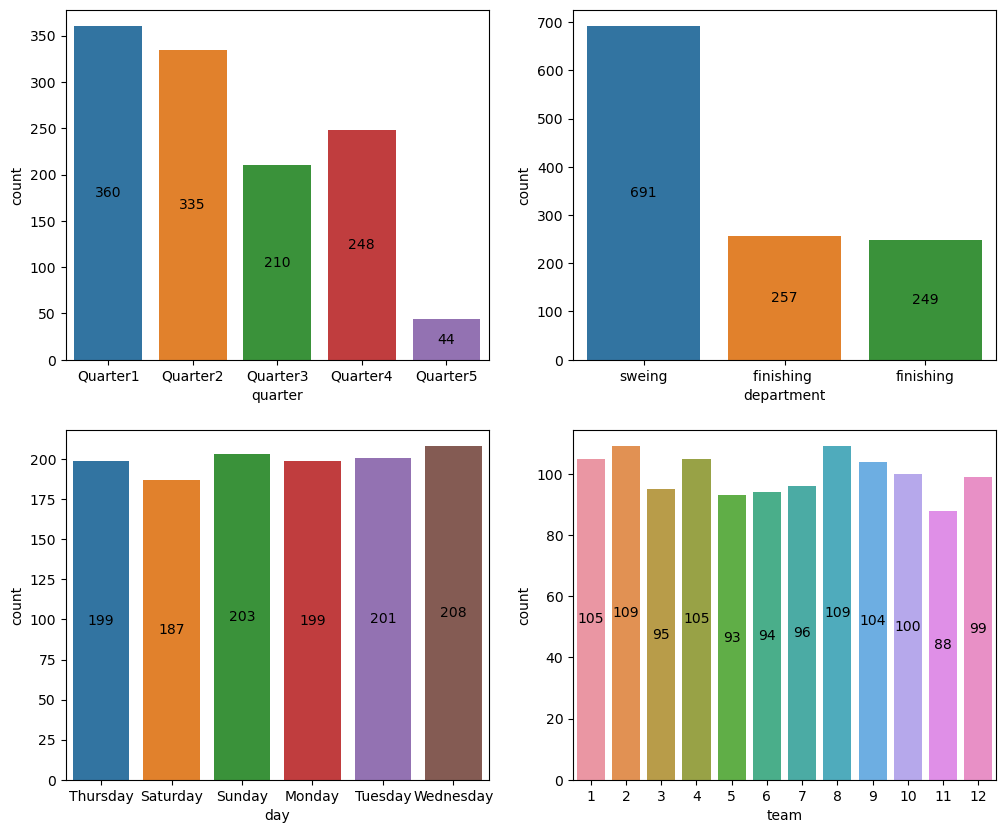

In [9]:
cat_cols = ['quarter', 'department', 'day',	'team']

fig = plt.figure(figsize=(12,10))

for idx, col in enumerate(cat_cols):
    ax = plt.subplot(2, 2, idx+1)
    sns.countplot(x=df[col], ax=ax)
    #add data label to each bar
    for container in ax.containers:
        ax.bar_label(container, label_type='center')

#### `quarter`

A bit misleading at first when considering company reports, `quarter` in this dataset is not referring to part of a year, but instead, in this dataset, it refers to part of a month.

Interestingly enough, there's 44 fifth quarters (`Quarter5`) entries. Let's explore them a little more.

In [10]:
# using a mask to get Quarter5 entries
df[df['quarter'] == 'Quarter5']

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
498,1/29/2015,Quarter5,sweing,Thursday,2,0.80,22.52,1416.0,6840,113,0.0,0,0,57.0,1.000230
499,1/29/2015,Quarter5,finishing,Thursday,4,0.80,4.30,NaN,1200,0,0.0,0,0,10.0,0.989000
500,1/29/2015,Quarter5,sweing,Thursday,3,0.80,22.52,1287.0,6840,100,0.0,0,0,57.0,0.950186
501,1/29/2015,Quarter5,sweing,Thursday,4,0.80,22.52,1444.0,6900,88,0.0,0,0,57.5,0.900800
502,1/29/2015,Quarter5,sweing,Thursday,10,0.80,22.52,1088.0,6720,88,0.0,0,0,56.0,0.900130
503,1/29/2015,Quarter5,finishing,Thursday,6,0.50,2.90,NaN,1200,0,0.0,0,0,10.0,0.899000
504,1/29/2015,Quarter5,finishing,Thursday,8,0.65,4.15,NaN,960,0,0.0,0,0,8.0,0.877552
505,1/29/2015,Quarter5,finishing,Thursday,11,0.60,2.90,NaN,960,0,0.0,0,0,8.0,0.864583
506,1/29/2015,Quarter5,finishing,Thursday,10,0.80,3.94,NaN,1200,0,0.0,0,0,10.0,0.856950
507,1/29/2015,Quarter5,finishing,Thursday,1,0.75,3.94,NaN,1200,0,0.0,0,0,10.0,0.853667


These "fifth" quarters are composed of either January 29 or 31.

#### `department`

There looks to be some misspellings in `department`. Let's dig a little deeper.

In [11]:
# unique string values in department
print(df['department'].unique())

#printing department column unique values and respective counts
for uniq, count in zip(df['department'].unique(), df['department'].value_counts()):
    print(f'{uniq}: {count}')

['sweing' 'finishing ' 'finishing']
sweing: 691
finishing : 257
finishing: 249


It looks like there's really only two departments in the company: sewing and finishing.
1. Sewing has been misspelled as `sweing`
2. `finishing` has been split in two thanks to errant trailing spaces in 257 entries

We'll address these typos when cleaning the dataset.

#### `day`

In [12]:
# displaying value counts for day column
df['day'].value_counts()

day
Wednesday    208
Sunday       203
Tuesday      201
Thursday     199
Monday       199
Saturday     187
Name: count, dtype: int64

Seems as thought there aren't any Friday observations. It's possible that the factory is closed on Fridays.

#### `team`

In [13]:
# value counts of team column sorted in ascending order
df["team"].value_counts().sort_index()
#| team number | number of observations |

team
1     105
2     109
3      95
4     105
5      93
6      94
7      96
8     109
9     104
10    100
11     88
12     99
Name: count, dtype: int64

#### `target_productivity` & `actual_productivity`

Each observation in these two columns are obviously worth comparing considering that they have to deal with un/realized expectations in production.

In [14]:
# observations where productivity was higher than expected
df[df['actual_productivity'] > df['targeted_productivity']]

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187,3/11/2015,Quarter2,sweing,Wednesday,4,0.75,26.82,1054.0,7080,45,0.0,0,0,59.0,0.750051
1188,3/11/2015,Quarter2,sweing,Wednesday,5,0.70,26.82,992.0,6960,30,0.0,0,1,58.0,0.700557
1189,3/11/2015,Quarter2,sweing,Wednesday,8,0.70,30.48,914.0,6840,30,0.0,0,1,57.0,0.700505
1190,3/11/2015,Quarter2,sweing,Wednesday,6,0.70,23.41,1128.0,4560,40,0.0,0,1,38.0,0.700246


There were 869 instances (~75% of all observations) where actual productivity exceeded expectations. 

What about the observations where the actual productivity was exactly equal to target productivity.

In [15]:
# observations where productivity exactly met targeted productivity
df[df['actual_productivity'] == df['targeted_productivity']]

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
163,1/10/2015,Quarter2,sweing,Saturday,10,0.8,28.08,1082.0,10530,63,0.0,0,0,58.5,0.8
182,1/11/2015,Quarter2,sweing,Sunday,2,0.8,28.08,805.0,10530,63,0.0,0,0,58.5,0.8
183,1/11/2015,Quarter2,sweing,Sunday,10,0.8,28.08,762.0,10530,38,0.0,0,0,58.5,0.8
207,1/12/2015,Quarter2,sweing,Monday,2,0.8,28.08,737.0,10530,63,0.0,0,0,58.5,0.8
229,1/13/2015,Quarter2,sweing,Tuesday,2,0.8,28.08,723.0,10530,50,0.0,0,0,58.5,0.8
855,2/19/2015,Quarter3,sweing,Thursday,8,0.7,29.40,1116.0,6240,0,0.0,0,2,57.0,0.7


Seeing as it's hard to find an exact match between the targeted productivity values and the actual ones, having only six observations in the whole dataset shouldn't be surprising.

Finally, let's check the observations where the actual productivity failed to meet the target.

In [16]:
# observations where productivity did not meet targeted productivity
df[df['actual_productivity'] < df['targeted_productivity']]

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
11,1/1/2015,Quarter1,sweing,Thursday,10,0.75,19.31,578.0,6480,45,0.0,0,0,54.0,0.712205
12,1/1/2015,Quarter1,sweing,Thursday,5,0.80,11.41,668.0,3660,50,0.0,0,0,30.5,0.707046
14,1/1/2015,Quarter1,finishing,Thursday,8,0.75,2.90,NaN,960,0,0.0,0,0,8.0,0.676667
15,1/1/2015,Quarter1,finishing,Thursday,4,0.75,3.94,NaN,2160,0,0.0,0,0,18.0,0.593056
16,1/1/2015,Quarter1,finishing,Thursday,7,0.80,2.90,NaN,960,0,0.0,0,0,8.0,0.540729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,3/11/2015,Quarter2,finishing,Wednesday,10,0.75,2.90,NaN,960,0,0.0,0,0,8.0,0.628333
1193,3/11/2015,Quarter2,finishing,Wednesday,8,0.70,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1194,3/11/2015,Quarter2,finishing,Wednesday,7,0.65,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1195,3/11/2015,Quarter2,finishing,Wednesday,9,0.75,2.90,NaN,1800,0,0.0,0,0,15.0,0.505889


In 322 instances (~25% of all observations) actual productivity failed to meet the targeted threshold.

Let's focus exclusively on the `actual_productivity` column and check all the observations where the range was higher than the stated maximum of 1.

In [17]:
# dataframe: observations where actual productivity exceeds 1
df[df['actual_productivity'] > 1]

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
337,1/20/2015,Quarter3,finishing,Tuesday,5,0.70,4.15,NaN,1440,0,0.0,0,0,8.0,1.033570
437,1/26/2015,Quarter4,finishing,Monday,3,0.75,3.94,NaN,1800,0,0.0,0,0,10.0,1.059621
456,1/27/2015,Quarter4,sweing,Tuesday,2,0.75,22.52,1635.0,6840,119,0.0,0,0,57.0,1.000230
457,1/27/2015,Quarter4,sweing,Tuesday,3,0.75,22.52,1299.0,6840,119,0.0,0,0,57.0,1.000230
477,1/28/2015,Quarter4,sweing,Wednesday,2,0.80,22.52,1559.0,6840,90,0.0,0,0,57.0,1.000230
478,1/28/2015,Quarter4,sweing,Wednesday,3,0.80,22.52,1350.0,6840,113,0.0,0,0,57.0,1.000230
498,1/29/2015,Quarter5,sweing,Thursday,2,0.80,22.52,1416.0,6840,113,0.0,0,0,57.0,1.000230
518,1/31/2015,Quarter5,sweing,Saturday,3,0.80,22.52,1136.0,6960,113,0.0,0,0,58.0,1.000457
519,1/31/2015,Quarter5,sweing,Saturday,2,0.80,22.52,1397.0,6840,113,0.0,0,0,57.0,1.000230
542,2/1/2015,Quarter1,finishing,Sunday,8,0.65,4.15,NaN,960,0,0.0,0,0,8.0,1.011562


In [18]:
# number of observations where actual productivity is over 1
df[df['actual_productivity'] > 1].shape[0]

37

#### `wip`

Column `wip` is where the number of unfinished items for products is recorded.

`wip` also happens to be the only column with missing observations.

In [19]:
# dataframe: observations where wip actually contains information
df[df['wip'].notnull()]

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382
5,1/1/2015,Quarter1,sweing,Thursday,7,0.80,25.90,984.0,6720,38,0.0,0,0,56.0,0.800125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187,3/11/2015,Quarter2,sweing,Wednesday,4,0.75,26.82,1054.0,7080,45,0.0,0,0,59.0,0.750051
1188,3/11/2015,Quarter2,sweing,Wednesday,5,0.70,26.82,992.0,6960,30,0.0,0,1,58.0,0.700557
1189,3/11/2015,Quarter2,sweing,Wednesday,8,0.70,30.48,914.0,6840,30,0.0,0,1,57.0,0.700505
1190,3/11/2015,Quarter2,sweing,Wednesday,6,0.70,23.41,1128.0,4560,40,0.0,0,1,38.0,0.700246


#### `over_time`

This column records the amount of overtime by each **team** in minutes. Let's see more statistical information of this column alone.

In [20]:
df['over_time'].describe()

count     1197.000000
mean      4567.460317
std       3348.823563
min          0.000000
25%       1440.000000
50%       3960.000000
75%       6960.000000
max      25920.000000
Name: over_time, dtype: float64

Let's explore the columns without overtime.

In [21]:
#dataframe: where there is no overtime
df[df['over_time'] == 0]

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
684,2/9/2015,Quarter2,sweing,Monday,11,0.75,10.05,103.0,0,45,0.0,0,0,54.0,0.750648
694,2/10/2015,Quarter2,sweing,Tuesday,10,0.80,22.52,1268.0,0,88,0.0,0,0,56.0,0.900632
695,2/10/2015,Quarter2,sweing,Tuesday,1,0.80,22.52,1546.0,0,88,0.0,0,0,57.0,0.900471
696,2/10/2015,Quarter2,sweing,Tuesday,3,0.80,22.52,813.0,0,88,0.0,0,0,57.0,0.900471
697,2/10/2015,Quarter2,sweing,Tuesday,2,0.80,22.52,1512.0,0,88,0.0,0,0,57.0,0.899984
713,2/11/2015,Quarter2,sweing,Wednesday,2,0.80,22.52,1557.0,0,90,0.0,0,0,57.5,1.000345
714,2/11/2015,Quarter2,sweing,Wednesday,1,0.80,22.52,1498.0,0,113,0.0,0,0,57.0,1.000066
718,2/11/2015,Quarter2,sweing,Wednesday,10,0.80,22.52,598.0,0,75,0.0,0,0,56.0,0.850365
730,2/12/2015,Quarter2,sweing,Thursday,1,0.80,22.52,1397.0,0,138,0.0,0,0,57.0,1.100484
732,2/12/2015,Quarter2,sweing,Thursday,2,0.80,22.52,1327.0,0,113,0.0,0,0,57.5,1.000345


In [22]:
# number of instances where there were no overtime
len(df[df['over_time'] == 0])

31

There are only 31 total observations without overtime.

Let's consider contrasting the `over_time` column with the ones related to productivity. We could start seeing how many observations we have where the productivity standards were met without overtime.

In [23]:
# dataframe: where overtime is zero and productivity exceeded expectations 
df[(df['over_time'] == 0) & (df['actual_productivity'] > df['targeted_productivity'])]

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
684,2/9/2015,Quarter2,sweing,Monday,11,0.75,10.05,103.0,0,45,0.0,0,0,54.0,0.750648
694,2/10/2015,Quarter2,sweing,Tuesday,10,0.80,22.52,1268.0,0,88,0.0,0,0,56.0,0.900632
695,2/10/2015,Quarter2,sweing,Tuesday,1,0.80,22.52,1546.0,0,88,0.0,0,0,57.0,0.900471
696,2/10/2015,Quarter2,sweing,Tuesday,3,0.80,22.52,813.0,0,88,0.0,0,0,57.0,0.900471
697,2/10/2015,Quarter2,sweing,Tuesday,2,0.80,22.52,1512.0,0,88,0.0,0,0,57.0,0.899984
713,2/11/2015,Quarter2,sweing,Wednesday,2,0.80,22.52,1557.0,0,90,0.0,0,0,57.5,1.000345
714,2/11/2015,Quarter2,sweing,Wednesday,1,0.80,22.52,1498.0,0,113,0.0,0,0,57.0,1.000066
718,2/11/2015,Quarter2,sweing,Wednesday,10,0.80,22.52,598.0,0,75,0.0,0,0,56.0,0.850365
730,2/12/2015,Quarter2,sweing,Thursday,1,0.80,22.52,1397.0,0,138,0.0,0,0,57.0,1.100484
732,2/12/2015,Quarter2,sweing,Thursday,2,0.80,22.52,1327.0,0,113,0.0,0,0,57.5,1.000345


It should be worrisome to realize that targets will mostly not be met without putting in overtime.

#### `incentive`
This colum is about the financial incentives that motivate a particular course of action. The following will highlight some important statistical characteristics of this column. 

In [24]:
df['incentive'].describe()

count    1197.000000
mean       38.210526
std       160.182643
min         0.000000
25%         0.000000
50%         0.000000
75%        50.000000
max      3600.000000
Name: incentive, dtype: float64

Incentives are pretty scarce for workers. And how many observations don't feature any kind of incentive?

In [25]:
len(df[df['incentive'] == 0])

604

604 observations where there were incentives is surprising. That's more than half of the entire dataset.

Let's see how many observations include incentives greater than the 75th percentile threshold (50).

In [26]:
# where incentive is greater than 75th percentile
df[df['incentive'] > 50]

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
27,1/3/2015,Quarter1,sweing,Saturday,12,0.80,26.16,844.0,7080,63,0.0,0,0,59.0,0.800319
32,1/3/2015,Quarter1,sweing,Saturday,10,0.75,19.31,610.0,6480,56,0.0,0,0,54.0,0.787300
45,1/4/2015,Quarter1,sweing,Sunday,9,0.80,26.16,1278.0,7080,60,0.0,0,0,59.0,0.850569
46,1/4/2015,Quarter1,sweing,Sunday,7,0.80,25.90,1227.0,7020,60,0.0,0,0,56.5,0.850436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1156,3/10/2015,Quarter2,sweing,Tuesday,4,0.75,26.82,1104.0,5880,65,0.0,0,0,59.0,0.850084
1158,3/10/2015,Quarter2,sweing,Tuesday,12,0.80,15.26,1069.0,4080,63,0.0,0,0,34.0,0.800402
1159,3/10/2015,Quarter2,sweing,Tuesday,3,0.80,30.10,756.0,6960,63,0.0,0,1,58.0,0.800072
1178,3/11/2015,Quarter2,sweing,Wednesday,12,0.80,15.26,470.0,4080,63,0.0,0,0,34.0,0.800402


The number is pretty small, only a third with respect to the number of observations without incentives. What happens if we only include observations with an incentive higher than 100?

In [27]:
df[df["incentive"] > 100]

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
456,1/27/2015,Quarter4,sweing,Tuesday,2,0.75,22.52,1635.0,6840,119,0.0,0,0,57.0,1.000230
457,1/27/2015,Quarter4,sweing,Tuesday,3,0.75,22.52,1299.0,6840,119,0.0,0,0,57.0,1.000230
478,1/28/2015,Quarter4,sweing,Wednesday,3,0.80,22.52,1350.0,6840,113,0.0,0,0,57.0,1.000230
498,1/29/2015,Quarter5,sweing,Thursday,2,0.80,22.52,1416.0,6840,113,0.0,0,0,57.0,1.000230
518,1/31/2015,Quarter5,sweing,Saturday,3,0.80,22.52,1136.0,6960,113,0.0,0,0,58.0,1.000457
519,1/31/2015,Quarter5,sweing,Saturday,2,0.80,22.52,1397.0,6840,113,0.0,0,0,57.0,1.000230
543,2/1/2015,Quarter1,sweing,Sunday,2,0.80,22.52,1396.0,6900,113,0.0,0,0,57.5,1.000671
544,2/1/2015,Quarter1,sweing,Sunday,1,0.80,22.94,1582.0,3060,113,0.0,0,0,58.5,1.000402
561,2/2/2015,Quarter1,sweing,Monday,1,0.80,22.94,16882.0,7020,113,0.0,0,0,58.5,1.000602
581,2/3/2015,Quarter1,sweing,Tuesday,1,0.80,22.52,1500.0,6900,113,0.0,0,0,57.5,1.000019


In [28]:
len(df[df["incentive"] > 100])

34

We only have 34 observations that meet this criteria.

#### `idle_time` & `idle_men`

What about all the observations where there were interruptions in the production process. 

In [29]:
df[df["idle_time"] > 0]

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
615,2/4/2015,Quarter1,sweing,Wednesday,5,0.65,30.10,326.0,5820,0,90.0,10,0,58.5,0.650835
617,2/4/2015,Quarter1,sweing,Wednesday,4,0.35,30.10,287.0,6060,23,150.0,15,0,55.5,0.350706
650,2/7/2015,Quarter1,sweing,Saturday,7,0.70,24.26,658.0,6960,0,270.0,45,0,58.0,0.662270
654,2/7/2015,Quarter1,sweing,Saturday,8,0.70,24.26,652.0,6840,0,300.0,37,0,57.0,0.365319
775,2/15/2015,Quarter3,sweing,Sunday,8,0.70,30.10,507.0,5880,40,2.0,10,1,59.0,0.700573
798,2/16/2015,Quarter3,sweing,Monday,8,0.70,30.10,7.0,7080,27,2.0,10,2,59.0,0.621972
818,2/17/2015,Quarter3,sweing,Tuesday,8,0.60,29.40,179.0,0,23,5.0,30,2,58.0,0.600983
822,2/17/2015,Quarter3,sweing,Tuesday,10,0.65,18.22,741.0,0,0,8.0,35,1,49.0,0.302117
841,2/18/2015,Quarter3,sweing,Wednesday,10,0.70,19.68,1119.0,5640,0,8.0,35,1,47.0,0.303574
843,2/18/2015,Quarter3,sweing,Wednesday,8,0.65,29.40,962.0,4560,0,4.5,30,2,57.0,0.251399


In [30]:
len(df[df['idle_time']> 0])

18

The factory rarely suffers from interruptions, with only 18 observations where something like this happened.

We can quickly double check if there are any inconsistencies between the two columns by seeing if...
1. There observations where there was idle time but no idle men.
2. The number of observations with idle men is similar to the number of observations with idle time.

In [31]:
# where idle time was present but no idle men
df[(df['idle_time'] > 0) & (df['idle_men'] == 0)]

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity


In [32]:
# number of observations with idle men
len(df[(df['idle_men'] > 0)])

18

With both columns matching and no contradictory observations present, we can confirm that there's nothing to worry about when it comes to these two columns.

#### `no_of_style_change`

This column has to do with the number of changes in the style of a particular product.

In [33]:
# statistical information on number of style changes
df['no_of_style_change'].describe()

count    1197.000000
mean        0.150376
std         0.427848
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: no_of_style_change, dtype: float64

We have another pretty uniform column here. Since the number of changes in the style of a particular product was pretty much 0 in most cases, it would be nice to have an idea of how many observations did feature these changes.

In [34]:
# instances where style changes did take place
df[df['no_of_style_change'] > 0]

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
634,2/5/2015,Quarter1,sweing,Thursday,4,0.50,30.10,417.0,6360,23,0.0,0,1,53.0,0.500720
651,2/7/2015,Quarter1,sweing,Saturday,4,0.60,30.10,486.0,6780,30,0.0,0,1,57.0,0.600224
671,2/8/2015,Quarter2,sweing,Sunday,4,0.65,30.10,712.0,6780,44,0.0,0,1,56.5,0.568260
683,2/9/2015,Quarter2,sweing,Monday,4,0.70,30.10,767.0,3300,50,0.0,0,1,57.0,0.790003
689,2/9/2015,Quarter2,sweing,Monday,7,0.35,30.10,842.0,6960,0,0.0,0,1,58.0,0.350302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185,3/11/2015,Quarter2,sweing,Wednesday,2,0.75,16.10,971.0,5400,45,0.0,0,1,45.0,0.750141
1188,3/11/2015,Quarter2,sweing,Wednesday,5,0.70,26.82,992.0,6960,30,0.0,0,1,58.0,0.700557
1189,3/11/2015,Quarter2,sweing,Wednesday,8,0.70,30.48,914.0,6840,30,0.0,0,1,57.0,0.700505
1190,3/11/2015,Quarter2,sweing,Wednesday,6,0.70,23.41,1128.0,4560,40,0.0,0,1,38.0,0.700246


In total, there were 147 observations in the whole dataset that included any change of the style of the product. 

#### `no_of_workers`

Exploring different observations that surpass a certain number of workers in each team could prove insightful.

In [35]:
# observations where number of workers is over the 75th percentile
df[df['no_of_workers'] > 57]

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
7,1/1/2015,Quarter1,sweing,Thursday,3,0.75,28.08,795.0,6900,45,0.0,0,0,57.5,0.753683
9,1/1/2015,Quarter1,sweing,Thursday,1,0.75,28.08,681.0,6900,45,0.0,0,0,57.5,0.750428
10,1/1/2015,Quarter1,sweing,Thursday,9,0.70,28.08,872.0,6900,44,0.0,0,0,57.5,0.721127
17,1/1/2015,Quarter1,sweing,Thursday,4,0.65,23.69,861.0,7200,0,0.0,0,0,60.0,0.521180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179,3/11/2015,Quarter2,sweing,Wednesday,3,0.80,30.10,735.0,6960,63,0.0,0,1,58.0,0.800072
1180,3/11/2015,Quarter2,sweing,Wednesday,11,0.80,11.41,560.0,3420,50,0.0,0,0,58.0,0.800035
1186,3/11/2015,Quarter2,sweing,Wednesday,1,0.75,26.82,1322.0,7080,45,0.0,0,0,59.0,0.750051
1187,3/11/2015,Quarter2,sweing,Wednesday,4,0.75,26.82,1054.0,7080,45,0.0,0,0,59.0,0.750051


 #### Exploratory Data Analysis - Summary
 Many of the columns in the dataset were imported into our workspace appropriately, but some others might need more attention and even some clean-up.
 - `date`
    - Could change its current `object` (string) data type to `datetime`
- `quarter`
    - Could be changed from `object` (string) to an integer
- `department`
    - typos present for both departments (sewing and finishing)
- `day`
     - could benefit from change of `object` (string) to an integer 
- `team`
    - 1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 - `wip`
     - has over 500 null values
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
- `no_of_workers`
    - There's isn't much of a reason why this column's data type should be `float64`
      actual_productivity    1197 non-null   float64

## Prepping the Dataset
Now that the columns have been explored, it's time to perform some data cleaning with the following objectives in mind:
1. Fix any incorrect observations that could present in our columns
2. Decide which columns we will keep to fit the decision tree

### Data Cleaning

In [36]:
# locating and replacing 'finishing ' with non-trailing space 'finishing'
df.loc[df['department'] == 'finishing ', 'department'] = 'finishing'

# locating and replacing 'sweing' with 'sewing'
df.loc[df['department'] == 'sweing', 'department'] = 'sewing'

#checking department value counts
df['department'].value_counts()

department
sewing       691
finishing    506
Name: count, dtype: int64

Regarding the `date` column, seeing as the timespan of the dates doesn't even reach a full yearly quarter, it's hard to imagine how it can offer much in terms of predictive power. 

In [37]:
# dropping date column
df = df.drop('date', axis=1)
df.head(2)

,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,Quarter1,sewing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500


Though the `quarter` column could be useful in terms of time-series analysis, its `Quarter5` will prove to gum up the analysis if left unaddressed. 

`Quater5` entries are only featured in 44 observations and only covers two days: January 29th and 31st. If we continue on as planned and create dummy variables for each of value in `quarty`, a column would be dedicated to just these 44 `Quarter5` entries. 

We're better off including in these `Quarter5` entries into `Quarter4` instead.

In [38]:
# replacing Quarter5 entries in quarters column with Quarter4   
df.loc[df['quarter'] == 'Quarter5', 'quarter'] = 'Quarter4'

# checking value counts for quarter column 
df['quarter'].value_counts()

quarter
Quarter1    360
Quarter2    335
Quarter4    292
Quarter3    210
Name: count, dtype: int64

One last thing as it concerns the values in the `quarter` column, it's unnecessary to feature the words "quarter" for every value. We can simply use integers to represent the same thing.

In [39]:
#dictionary to map quarters to integers
quarter_map = {'Quarter1': 1,'Quarter2': 2,'Quarter3': 3,'Quarter4': 4}

# applying map to quarter column
df['quarter'] = df['quarter'].map(quarter_map)

#checking counts
df['quarter'].value_counts()

quarter
1    360
2    335
4    292
3    210
Name: count, dtype: int64

In [40]:
# checking quarter column data type is int
df['quarter'].dtype

dtype('int64')

Seeing as there are only 18 observations with non-zero values and don't really provide much information, we'll drop columns `idle_time` and `idle_men`.

In [41]:
df = df.drop(['idle_time', 'idle_men'], axis=1)
df.head(2)

,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,no_of_style_change,no_of_workers,actual_productivity
0,1,sewing,Thursday,8,0.80,26.16,1108.0,7080,98,0,59.0,0.940725
1,1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0,8.0,0.886500


The `wip` column not only has a lot of empty observations, it's also hard to tell if the empty cells in `wip` column correspond to zero unfinished products or if the information is simply missing. 

This uncertainty leads us to dropping the column entirely.

In [42]:
df = df.drop('wip', axis=1)
df.head(2)

,quarter,department,day,team,targeted_productivity,smv,over_time,incentive,no_of_style_change,no_of_workers,actual_productivity
0,1,sewing,Thursday,8,0.80,26.16,7080,98,0,59.0,0.940725
1,1,finishing,Thursday,1,0.75,3.94,960,0,0,8.0,0.886500


`no_of_style_changes` doesn't hold much information in of itself, and there doesn't seem to be many observations where changes did take place.

We've dropped all the columns we don't want to work with any further. Now, we'll need to assess the data types of each column left.

Pulling up the remaining columns and their data types....

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   quarter                1197 non-null   int64  
 1   department             1197 non-null   object 
 2   day                    1197 non-null   object 
 3   team                   1197 non-null   int64  
 4   targeted_productivity  1197 non-null   float64
 5   smv                    1197 non-null   float64
 6   over_time              1197 non-null   int64  
 7   incentive              1197 non-null   int64  
 8   no_of_style_change     1197 non-null   int64  
 9   no_of_workers          1197 non-null   float64
 10  actual_productivity    1197 non-null   float64
dtypes: float64(4), int64(5), object(2)
memory usage: 103.0+ KB


There's no reason why `no_of_workers` should be a float. You can't have a fraction of a worker in any given observation, so we'll instead change this to an integer instead. 

In [44]:
df['no_of_workers'] = df['no_of_workers'].astype('int64')
df.head(2)

,quarter,department,day,team,targeted_productivity,smv,over_time,incentive,no_of_style_change,no_of_workers,actual_productivity
0,1,sewing,Thursday,8,0.80,26.16,7080,98,0,59,0.940725
1,1,finishing,Thursday,1,0.75,3.94,960,0,0,8,0.886500


`actual_productivity` should more closely conform to `targeted_productivity` have its float values rounded to two decimals places.

In [45]:
# rounding actual_productivity to two decimal places
df['actual_productivity'] = df['actual_productivity'].round(2)
df.head(2)

,quarter,department,day,team,targeted_productivity,smv,over_time,incentive,no_of_style_change,no_of_workers,actual_productivity
0,1,sewing,Thursday,8,0.80,26.16,7080,98,0,59,0.94
1,1,finishing,Thursday,1,0.75,3.94,960,0,0,8,0.89


Now that we've done our best to clean up the dataset, it's time to prepare the data structurally for modeling. 

### Data Wrangling

Seeing that we are building a Classification Tree (and not a Regression Tree), our target column `actual_productivity` must be categorical, not numerical.

To accomplish this, a new column will be created and feature boolean values indicating if the productivity targets were achieved for each observation in the dataset.

In [46]:
df['productive'] = df['actual_productivity'] >= df['targeted_productivity']
df.sample(10, random_state=14)

,quarter,department,day,team,targeted_productivity,smv,over_time,incentive,no_of_style_change,no_of_workers,actual_productivity,productive
959,4,finishing,Thursday,10,0.70,2.90,3360,0,0,8,0.41,False
464,4,finishing,Tuesday,8,0.65,3.94,960,0,0,8,0.85,True
672,2,sewing,Sunday,7,0.70,24.26,6960,0,0,58,0.36,False
321,3,sewing,Monday,6,0.80,11.41,4380,50,0,31,0.80,True
282,3,finishing,Saturday,9,0.80,3.94,1800,0,0,10,0.83,True
307,3,sewing,Sunday,10,0.70,22.52,10080,40,0,56,0.70,True
609,1,finishing,Wednesday,9,0.75,3.94,960,0,0,8,0.76,True
1123,2,sewing,Sunday,8,0.60,30.48,6720,0,1,56,0.60,True
877,4,sewing,Sunday,9,0.70,18.79,3240,30,1,57,0.63,False
950,4,sewing,Thursday,3,0.75,29.40,6840,45,2,57,0.75,True


Reordering the columns will make the dataset easier to read.

In [47]:
# reordering the dataset's columns for better readability
df = df[["quarter", "day", "department", "team", "no_of_workers", "targeted_productivity", 
        "actual_productivity", "productive", "over_time", "smv", "incentive"]]

# information on the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   quarter                1197 non-null   int64  
 1   day                    1197 non-null   object 
 2   department             1197 non-null   object 
 3   team                   1197 non-null   int64  
 4   no_of_workers          1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   actual_productivity    1197 non-null   float64
 7   productive             1197 non-null   bool   
 8   over_time              1197 non-null   int64  
 9   smv                    1197 non-null   float64
 10  incentive              1197 non-null   int64  
dtypes: bool(1), float64(3), int64(5), object(2)
memory usage: 94.8+ KB


#### Encoding

In [48]:
encoder = OneHotEncoder(sparse_output=False, dtype='int64')

# use encoder for columns that are categorical or where the numbers cannot be ranked
df_encoded = encoder.fit_transform(df[['quarter', 'day', 'department', 'team']])
encoded_column_names = encoder.get_feature_names_out(input_features=['quarter', 'day', 'department', 'team'])
encoded_df = pd.DataFrame(df_encoded, columns = encoded_column_names)

df_coded = pd.concat([df, encoded_df], axis=1)
df_coded = df_coded.drop(['quarter', 'day', 'department', 'team'], axis=1)

In [ ]:
df_coded.info()

In [50]:
X = df_coded.drop(['actual_productivity','productive'], axis=1)
y = df_coded['productive']

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=42)

In [52]:
tree = DecisionTreeClassifier(max_depth=3, random_state=42)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [53]:
y_pred = tree.predict(X_test)

In [54]:
print('Accuracy:', round(accuracy_score(y_test, y_pred), 3))

Accuracy: 0.85


The model is now instantiated and fitted to the data. On to visualizing the results.

## Visualizing the Evaluation Tree

Using the plot_tree library, we can generate some insightful visualizations. 

In [55]:
tree.classes_

array([False,  True])

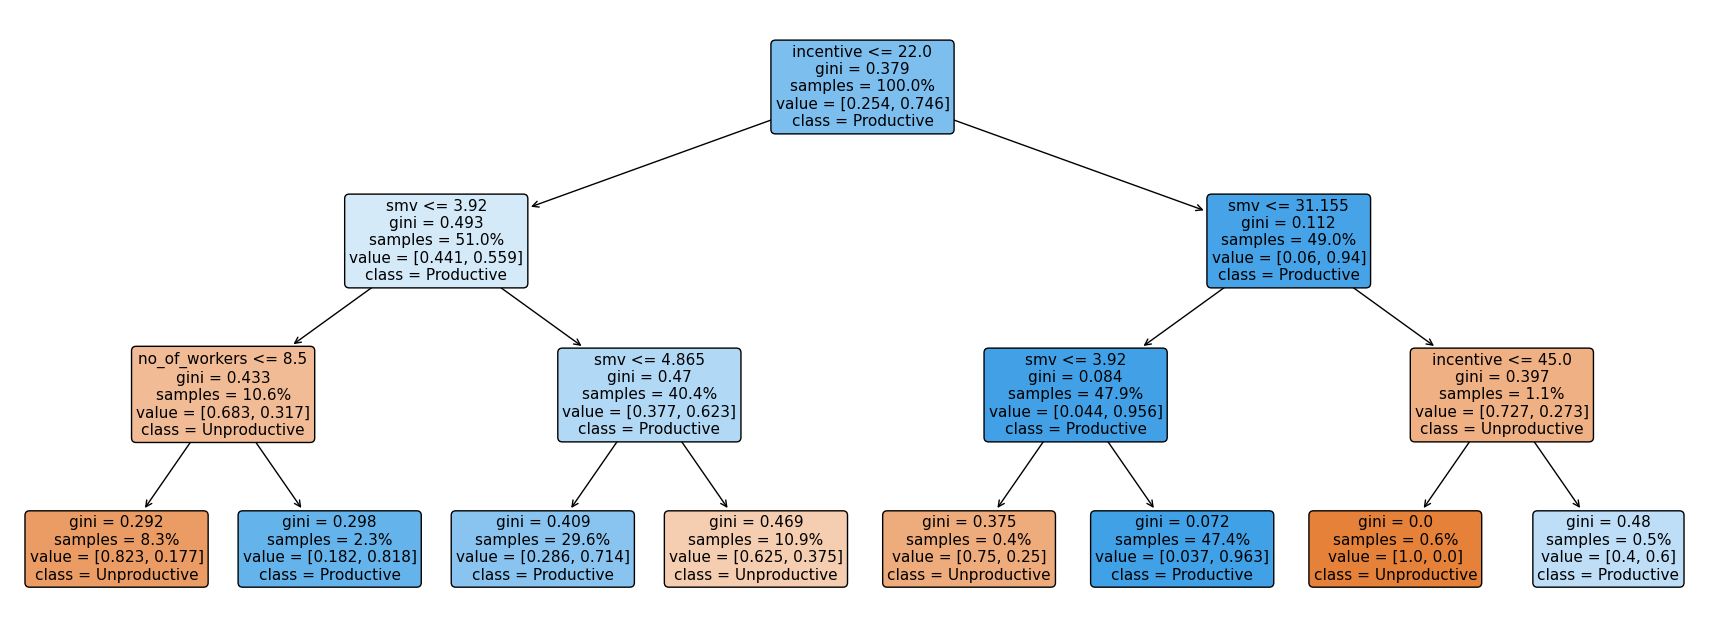

In [61]:
plt.rcParams['figure.figsize'] = [22.0, 8.0]
_ = plot_tree(tree,
              feature_names=X.columns.tolist(),
              class_names= ['Unproductive', 'Productive'],
              filled=True, #nodes filled with color
              proportion=True,
              precision=3, #number of decimals
              rounded=True, #rounded nodes
              fontsize=11)
plt.show()

In [57]:
print('Accuracy:', round(tree.score(X_test, y_test), 3))

Accuracy: 0.85


## Explaining the Tree

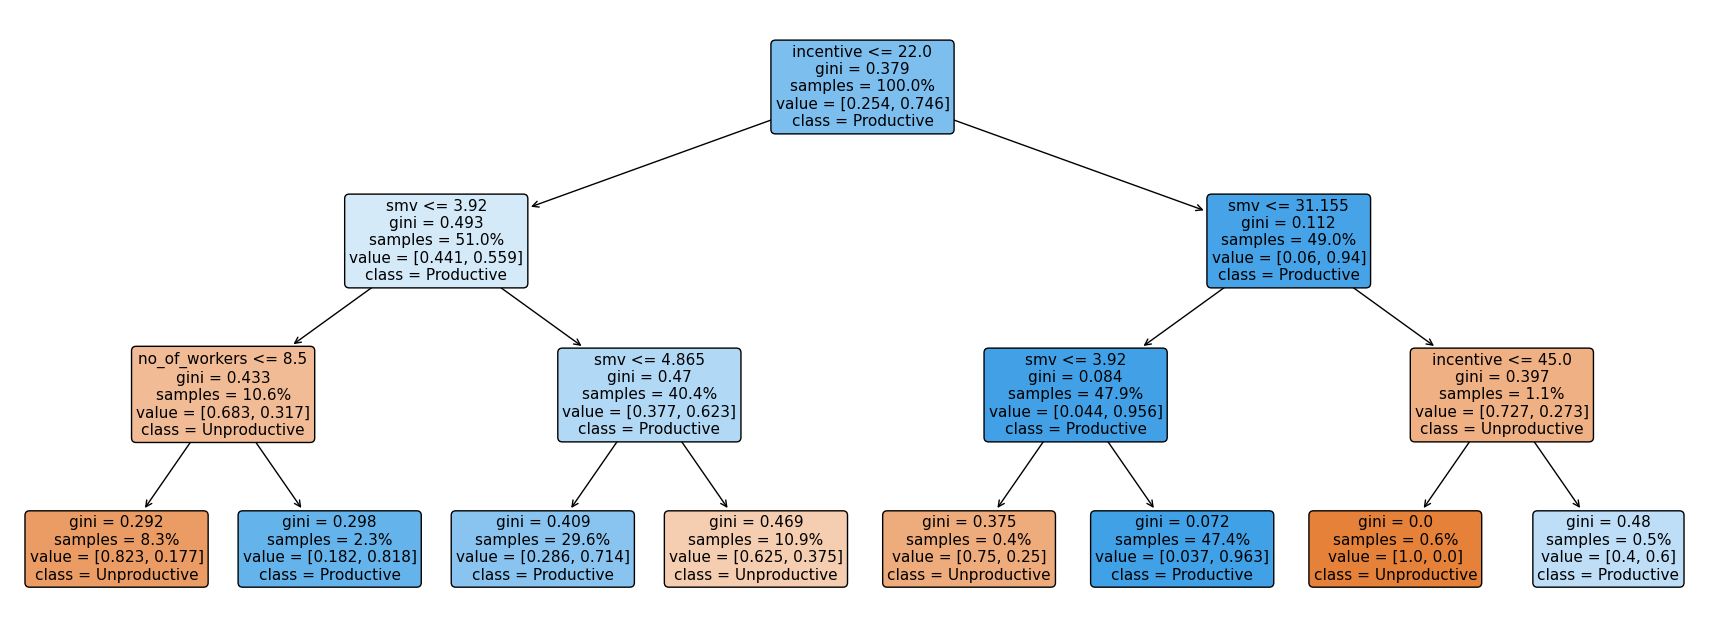

In [62]:
plt.rcParams['figure.figsize'] = [22, 8]

_ = plot_tree(tree,
              feature_names=X.columns.tolist(),
              class_names= ['Unproductive', 'Productive'],
              filled=True, #nodes filled with color
              proportion=True,
              precision=3, #number of decimals
              rounded=True, #rounded nodes
              fontsize=11)
plt.show()

The goal of this analysis is to determine what aspects of the production cycle are best at predicting if a team will be productive or not. 

Boasting an accuracy score of 85%, the model itself is quite robust. 

The Decision Tree
The graphic illustrates which aspects of the factory are best at predicting if a team will be productive or not. These aspects include variables like date, department, team number, etc. In our case, we see "incentive" and the "smv" variables were the ones with the greatest influence on the final prediction. This is evident by the fact that these two variables appear the most often at the top of each of boxes! To provide context, the "incentive" variable represents the amount of financial incentive offered to motivate a particular course of action. The "smv" (Standard Minute Value) variable represents the time allocated for a specific task

The algorithm is called a Decision Tree thanks to the way it resembles an (upside-down) tree with the top box (the "root") representing the most predictive feature and the boxes at the bottom (the "leaves") providing the predictions. These terminal boxes (again, the "leaves") are the ones that tell us whether a team is a specific department was productive or not. You might have noticed that the classes for these leaves are categorized as either "Productive" or "Unproductive". If you'd prefer, you could instead focus on the color of the boxes leaves instead: blue is "Productive" and orange is "Unproductive". 

Which path should be taken from the top box to the final ones? The answer to that question lies in the thresholds associated with every variable (located at the top of box). We compare our inputs with those thresholds – starting from the root – until we reach the leaves at the bottom. By "input" we are referring to the corresponding "incentives" and "smv" values for a particular team. These values can be obtained from any chosen date in the dataset or the values can be self-selected to test hypothetical situations. This means the Decision Tree can be used to predict the outcome for future and/or hypothetical scenarios.

An example: a fictional date where the **"incentive" is 22** and **"smv" is 4.44** to predict if a team will be productive or not under these conditions. 
1. Starting from the root, the first comparison will be 22 <= 22 when we substitute "incentive" for 22. This comparison is true and we follow the left arrow to the next box.
    - Note: This is a universal rule of Decision Trees: if the assertion is True, we continue to the left; otherwise, if it's False, we continue to the right. (True = Left)
2. At the next box, is our smv value of 4.44 less than or equal to 3.92? (4.44 <= 3.92). Obviously, not not the case so we move down and to the right (False = Right).
3. Again, we compare our "smv" value of 4.44 and we determine if is less than or equal to this variable's "smv" threshold. In this case, our "smv"'s value of 4.44 is indeed less than or equal to 4.865. Evaluating as true means moving down and to the left once more.
4. Finally, seeing as there are no other nodes we could drop down to, we have reached our conclusion: if we have a team with an "incentive" of 22 and a SMV of 4.44, it will be a productive team!

To summarize, the Decision Tree not only told us which variables have the strongest predictive power ("incentive" and "smv"), but it also allows us to make predictions using values of our own choosing. This is the power of Decision Trees!

## Using Random Forest



### Feature Selection
- Is the column providing me with information that would give valuable insights in a decision tree, or is it superfluous and/or unrelated?
- Does the column contain data that is similar enough to another column that we only need to keep one?
- How many missing values does the column have? Can we work around them? Is there a way that we could reduce them (for instance, by transforming other columns)? What would happen if we didn't use the column? Would this negatively change the effectiveness of the others?
- Does the column feature the appropriate data type to fit a decision tree? If not, what options do we have to transform the values?
- Is there a chance that we could create a new and useful column based on the combined information of two other columns?
- Would changing the column order in the dataset improve its readability?

# Conclusions